# Resource competition for zooplankton in the Southern Ocean
### prey concentration versus temperature

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math
import cmocean

#### ACC 1920s

In [2]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_ACC-1920s.nc'
ds_acc_1920s=xr.open_dataset(file)

#### ACC 2090s

In [3]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_ACC-2090s.nc'
ds_acc_2090s=xr.open_dataset(file)

#### SIZ 1920s

In [4]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_SIZ-1920s.nc'
ds_siz_1920s=xr.open_dataset(file)

#### SIZ 2090s

In [5]:
file = '/glade/scratch/kristenk/CESM-LE-output/seasonal_upper_50m_means_SIZ-2090s.nc'
ds_siz_2090s=xr.open_dataset(file)

In [7]:
ds_acc_1920s.spC_50m_zint

<xarray.DataArray 'spC_50m_zint' (season: 4)>
array([86.361581, 24.361894, 14.043583, 55.793428])
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
Attributes:
    long_name:     50m depth-integrated small phytoplankton carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

## start work on resource competition, parameter values are from CESM1

#### cycle through values and calculate grazing rate for sp and diat, taking difference

In [49]:
### Specify parameters
Tref = 30.
q10 = 2.0

Gmax_sp = 2.5 #per day
Gmax_diat = 1.95 #per day

km_sp = 1 #mmol/m3
km_diat = 0.84 #mmol/m3

## biomass ranges
phytoC_vals = np.arange(0,3.5,0.035)
temp_vals = np.arange(-4,16,0.2)

## initialize empty matrices
sp_grazingrate = np.full((100,100),np.nan)
diat_grazingrate = np.full((100,100),np.nan)

i=0
j=0

for phytoC in phytoC_vals: # i loop
    
    for T in temp_vals: # j loop
        
        Tfunc = q10**((T - Tref) / 10.)
        
        ##### small phytoplankton
        spC_lim = (phytoC**2)/(phytoC**2 + km_sp**2)
        
        sp_grazingrate[j,i] = Gmax_sp * Tfunc * spC_lim
        
        #### diatoms
        diatC_lim = (phytoC**2)/(phytoC**2 + km_diat**2)
        
        diat_grazingrate[j,i] = Gmax_diat * Tfunc * diatC_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_grazingrate = xr.DataArray(sp_grazingrate,dims=('phytoC_vals','temp_vals'))
diat_grazingrate = xr.DataArray(diat_grazingrate,dims=('phytoC_vals','temp_vals'))

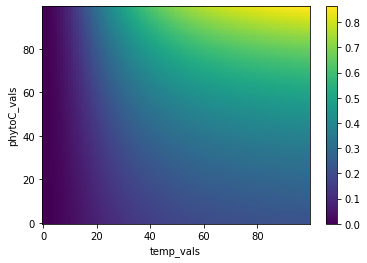

In [50]:
sp_grazingrate.plot()

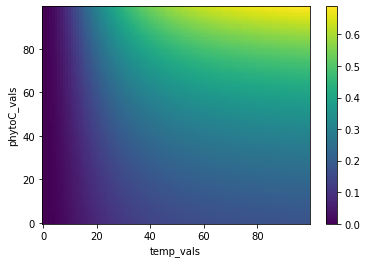

In [51]:
diat_grazingrate.plot()

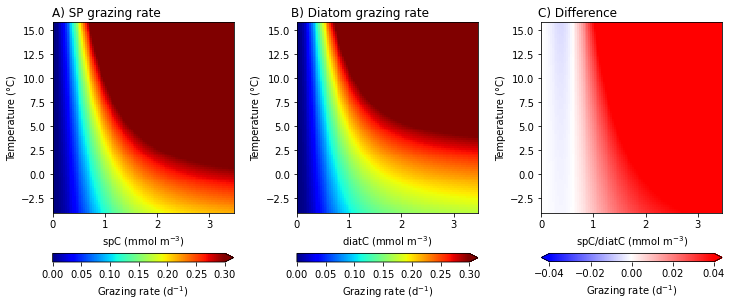

In [52]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,3,1)
ax.set_title('A) SP grazing rate', x=0.3)
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate,cmap='jet',vmin=0,vmax=0.3)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('spC (mmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Grazing rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,2)
ax.set_title('B) Diatom grazing rate', x=0.35)
pc=ax.pcolormesh(phytoC_vals, temp_vals, diat_grazingrate,cmap='jet',vmin=0,vmax=0.3)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('diatC (mmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Grazing rate (d$^{-1}$)',orientation='horizontal')

ax = fig.add_subplot(1,3,3)
ax.set_title('C) Difference', x=0.2)
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate-diat_grazingrate,cmap='bwr',vmin=-0.04,vmax=0.04)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('spC/diatC (mmol m$^{-3}$)')
#labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
#ax.set_xticklabels(labels)
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)',orientation='horizontal')

cbar = fig.colorbar(pc, ax=ax,extend='both',label='Grazing rate (d$^{-1}$)',orientation='horizontal') #, ticks=[-0.1,-0.05,0,0.05,0.1])
#cbar.ax.set_yticklabels(['-0.1','-0.05','0','0.05','0.1']) 

plt.subplots_adjust(wspace=0.35)

#fig.savefig('/glade/work/kristenk/figs/example_resource_comp.png', bbox_inches='tight', dpi=300, format='png');

In [53]:
SIZ_plotvals_2090s = xr.concat([ds_siz_2090s, ds_siz_2090s.isel(season=0)],dim='season')
SIZ_plotvals_1920s = xr.concat([ds_siz_1920s, ds_siz_1920s.isel(season=0)],dim='season')
ACC_plotvals_2090s = xr.concat([ds_acc_2090s, ds_acc_2090s.isel(season=0)],dim='season')
ACC_plotvals_1920s = xr.concat([ds_acc_1920s, ds_acc_1920s.isel(season=0)],dim='season')

In [54]:
annotations = ds_acc_1920s.season.values

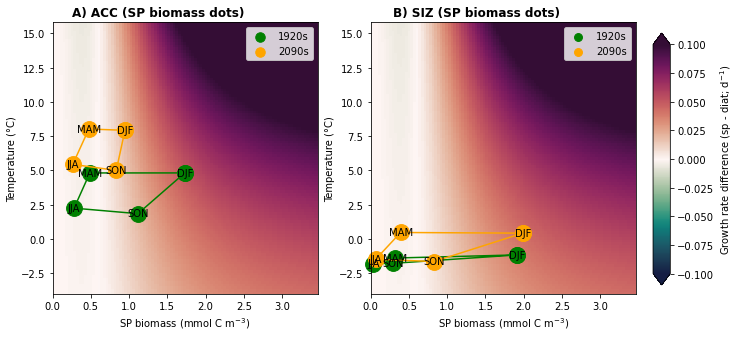

In [77]:
fig = plt.figure(figsize=(12,5))


######################################################### ACC
ax = fig.add_subplot(1,2,1)

ax.set_title('A) ACC (SP biomass dots)',x=0.4,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate-diat_grazingrate,cmap=cmocean.cm.curl,vmin=-0.1,vmax=0.1)
ax.set_xlabel('SP biomass (mmol C m$^{-3}$)')
ax.set_ylabel('Temperature (°C)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(ACC_plotvals_1920s.spC_50m_zint.values/50.,ACC_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(ACC_plotvals_1920s.spC_50m_zint.values/50.,ACC_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(ACC_plotvals_2090s.spC_50m_zint.values/50.,ACC_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(ACC_plotvals_2090s.spC_50m_zint.values/50.,ACC_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_acc_1920s.spC_50m_zint.values[0]/50., ds_acc_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_acc_1920s.spC_50m_zint.values[1]/50., ds_acc_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_acc_1920s.spC_50m_zint.values[2]/50., ds_acc_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_acc_1920s.spC_50m_zint.values[3]/50., ds_acc_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_acc_2090s.spC_50m_zint.values[0]/50., ds_acc_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_acc_2090s.spC_50m_zint.values[1]/50., ds_acc_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_acc_2090s.spC_50m_zint.values[2]/50., ds_acc_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_acc_2090s.spC_50m_zint.values[3]/50., ds_acc_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')


ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
# ### add x axis labels in nmol/m3
# labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
# ax.set_xticklabels(labels)

######################################################### SIZ

ax = fig.add_subplot(1,2,2)

ax.set_title('B) SIZ (SP biomass dots)', x=0.4,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate-diat_grazingrate,cmap=cmocean.cm.curl,vmin=-0.1,vmax=0.1)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('SP biomass (mmol C m$^{-3}$)')

#1920s
#s = [SIZ_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s',clip_on=False,zorder=1)
ax.plot(SIZ_plotvals_1920s.spC_50m_zint.values/50.,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #1990s
#s = [SIZ_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_plotvals_2090s.spC_50m_zint.values/50.,SIZ_plotvals_2090s.TEMP_50m_mean.values,
       color='orange',zorder=2)

# # add season labels
plt.annotate(annotations[0], (ds_siz_1920s.spC_50m_zint.values[0]/50., ds_siz_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.spC_50m_zint.values[1]/50., ds_siz_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.spC_50m_zint.values[2]/50., ds_siz_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.spC_50m_zint.values[3]/50., ds_siz_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.spC_50m_zint.values[0]/50., ds_siz_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.spC_50m_zint.values[1]/50., ds_siz_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.spC_50m_zint.values[2]/50., ds_siz_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.spC_50m_zint.values[3]/50., ds_siz_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

ax.legend(markerscale=0.5,scatterpoints=1, fontsize=10)

# labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
# ax.set_xticklabels(labels)

# #plt.annotate('Total biomass', (0.0005, 3), fontsize=14)
# plt.figtext(0.912, 0.8, 'Total biomass', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

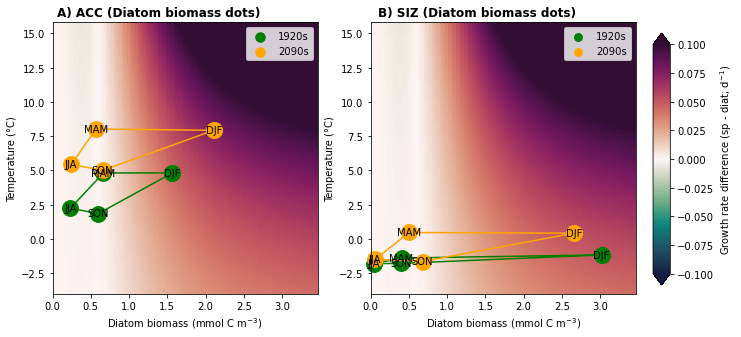

In [78]:
fig = plt.figure(figsize=(12,5))


######################################################### ACC
ax = fig.add_subplot(1,2,1)

ax.set_title('A) ACC (Diatom biomass dots)',x=0.4,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate-diat_grazingrate,cmap=cmocean.cm.curl,vmin=-0.1,vmax=0.1)
ax.set_xlabel('Diatom biomass (mmol C m$^{-3}$)')
ax.set_ylabel('Temperature (°C)')

#1920s
#s = [ACC_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(ACC_plotvals_1920s.diatC_50m_zint.values/50.,ACC_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s', zorder=1)
ax.plot(ACC_plotvals_1920s.diatC_50m_zint.values/50.,ACC_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #2090s
#s = [ACC_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(ACC_plotvals_2090s.diatC_50m_zint.values/50.,ACC_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',zorder=2)
ax.plot(ACC_plotvals_2090s.diatC_50m_zint.values/50.,ACC_plotvals_2090s.TEMP_50m_mean.values,
        color='orange',zorder=2)

## add season labels
plt.annotate(annotations[0], (ds_acc_1920s.diatC_50m_zint.values[0]/50., ds_acc_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_acc_1920s.diatC_50m_zint.values[1]/50., ds_acc_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_acc_1920s.diatC_50m_zint.values[2]/50., ds_acc_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_acc_1920s.diatC_50m_zint.values[3]/50., ds_acc_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_acc_2090s.diatC_50m_zint.values[0]/50., ds_acc_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_acc_2090s.diatC_50m_zint.values[1]/50., ds_acc_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_acc_2090s.diatC_50m_zint.values[2]/50., ds_acc_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_acc_2090s.diatC_50m_zint.values[3]/50., ds_acc_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
# ### add x axis labels in nmol/m3
# labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
# ax.set_xticklabels(labels)

######################################################### SIZ

ax = fig.add_subplot(1,2,2)

ax.set_title('B) SIZ (Diatom biomass dots)', x=0.4,y=1, fontsize=12, fontweight='bold')
pc=ax.pcolormesh(phytoC_vals, temp_vals, sp_grazingrate-diat_grazingrate,cmap=cmocean.cm.curl,vmin=-0.1,vmax=0.1)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Diatom biomass (mmol C m$^{-3}$)')

#1920s
#s = [SIZ_plotvals_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_1920s.diatC_50m_zint.values/50.,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        marker='o',s=250,color='green',label='1920s',clip_on=False,zorder=1)
ax.plot(SIZ_plotvals_1920s.diatC_50m_zint.values/50.,SIZ_plotvals_1920s.TEMP_50m_mean.values,
        color='green',zorder=1)

# #1990s
#s = [SIZ_plotvals_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_plotvals_2090s.diatC_50m_zint.values/50.,SIZ_plotvals_2090s.TEMP_50m_mean.values,
        marker='o',s=250,color='orange',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_plotvals_2090s.diatC_50m_zint.values/50.,SIZ_plotvals_2090s.TEMP_50m_mean.values,
       color='orange',zorder=2)

# # add season labels
plt.annotate(annotations[0], (ds_siz_1920s.diatC_50m_zint.values[0]/50., ds_siz_1920s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_1920s.diatC_50m_zint.values[1]/50., ds_siz_1920s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_1920s.diatC_50m_zint.values[2]/50., ds_siz_1920s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_1920s.diatC_50m_zint.values[3]/50., ds_siz_1920s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')

plt.annotate(annotations[0], (ds_siz_2090s.diatC_50m_zint.values[0]/50., ds_siz_2090s.TEMP_50m_mean.values[0]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[1], (ds_siz_2090s.diatC_50m_zint.values[1]/50., ds_siz_2090s.TEMP_50m_mean.values[1]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[2], (ds_siz_2090s.diatC_50m_zint.values[2]/50., ds_siz_2090s.TEMP_50m_mean.values[2]-0.2), fontsize=10, ha='center')
plt.annotate(annotations[3], (ds_siz_2090s.diatC_50m_zint.values[3]/50., ds_siz_2090s.TEMP_50m_mean.values[3]-0.2), fontsize=10, ha='center')
ax.legend(markerscale=0.5,scatterpoints=1, fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');